<a href="https://colab.research.google.com/github/quenting44/GAN_and_cGAN/blob/master/BE2_GAN_and_cGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 ><big><center>MSO 3.4 - Deep Structured Learning</center></big></h1>

<h3><big><center>Emmanuel Dellandréa, Amaury Depierre, Liming Chen</center></big></h3>


<h2><big><center> BE 2 - GANs and cGAN </center></big></h2>

<h5><big><center>Adapted from <i>Projet d'Option</i> of : Mhamed Jabri, Martin Chauvin, Ahmed Sahraoui, Zakariae Moustaïne and Taoufik Bouchikhi


<p align="center">
<img height=300px src="https://cdn-images-1.medium.com/max/1080/0*tJRy5Chmk4XymxwN.png"/></p>
<p align="center"></p>

The aim of this assignment is to discover GANs, understand how they are implemented and then explore one specific architecture of GANs that allows us to perform image to image translation (which corresponds to the picture that you can see above this text ! )

Before starting the exploration of the world of GANs, here's  what students should do and send back for this assignement : 
* In the "tutorial" parts of this assignement that focus on explaining new concepts, you'll find <font color='red'>**questions**</font>  that aim to test your understanding of those concepts. 
* In some of the code cells, you'll have to complete the code and you'll find a "TO DO" explaining what you should implement.

# Part1: DC-GAN

In this part, we aim to learn and understand the basic concepts of **Generative Adversarial Networks** through a DCGAN and generate new celebrities from the learned network after showing it real celebrities. For this purpose, please study the tutorial here: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html


##Work to do
Now we want to generate handwritten digits using the MNIST dataset. It is available within torvision package (https://pytorch.org/docs/stable/torchvision/datasets.html#mnist)

Please re-train the DCGAN and display some automatically generated handwritten digits.



Random Seed:  999


Extracting data/celeba/MNIST/raw/train-images-idx3-ubyte.gz to data/celeba/MNIST/raw


Extracting data/celeba/MNIST/raw/train-labels-idx1-ubyte.gz to data/celeba/MNIST/raw


Extracting data/celeba/MNIST/raw/t10k-images-idx3-ubyte.gz to data/celeba/MNIST/raw


Extracting data/celeba/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/celeba/MNIST/raw
Processing...
Done!
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvT

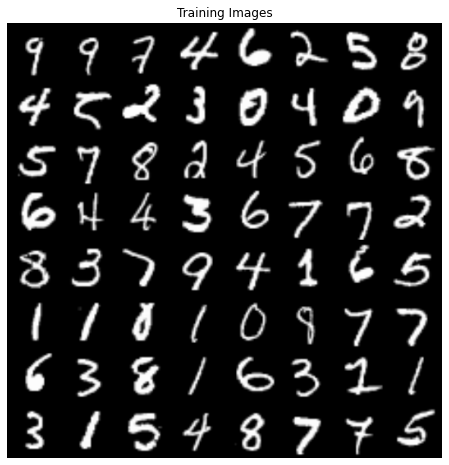

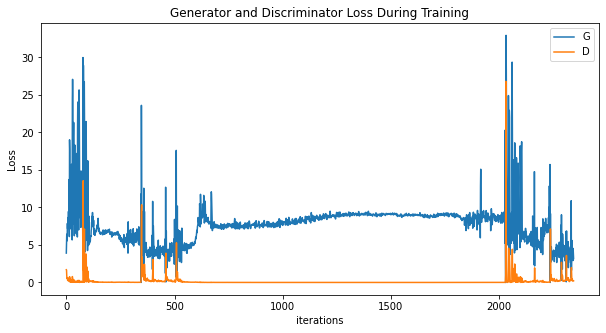

In [1]:
#TO DO: your code here to adapt the code from the tutorial to experiment
# on MNIST dataset

from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Root directory for dataset
dataroot = "data/celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1


# We can use an image folder dataset the way we have it setup.
# Create the dataset
# dataset = dset.ImageFolder(root=dataroot,
#                            transform=transforms.Compose([
#                                transforms.Resize(image_size),
#                                transforms.CenterCrop(image_size),
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#                            ]))

dataset = dset.MNIST(root=dataroot, train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize(image_size),
                           transforms.CenterCrop(image_size),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)



# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)


class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)




# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1



plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


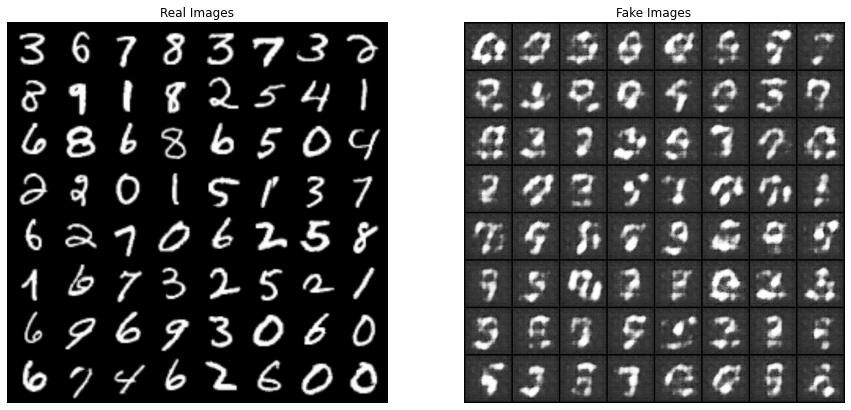

In [2]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

# Part2: Conditional GAN (cGAN)

Let's take the example of the set described in the next picture.
![Map to satellite picture](https://raw.githubusercontent.com/Neyri/Projet-cGAN/master/BE/img/map_streetview.png)

We have a picture of a map (from Google Maps) and we want to create an image of what the satellite view may look like.

As we are not only trying to generate a random picture but a mapping between a picture to another one, we can't use the standard GAN architecture. We will then use a cGAN.

A cGAN is a supervised GAN aiming at mapping a label picture to a real one or a real picture to a label one. As you can see in the diagram below, the discriminator will take as input a pair of images and try to predict if the pair was generated or not. The generator will not only generate an image from noise but will also use an image (label or real) to generate another one (real or label).
![Diagram of how a cGan works](https://raw.githubusercontent.com/Neyri/Projet-cGAN/master/BE/img/cgan_map.png)


### Generator

In the cGAN architecture, the generator chosen is a U-Net.
![U-Net](https://raw.githubusercontent.com/Neyri/Projet-cGAN/master/BE/img/unet.png)

A U-Net takes as input an image, and outputs another image. 

It can be divided into 2 subparts : an encoder and a decoder. 
* The encoder takes the input image and reduces its dimension to encode the main features into a vector. 
* The decoder takes this vector and map the features stored into an image.

A U-Net architecture is different from a classic encoder-decoder in that every layer of the decoder takes as input the previous decoded output as well as the output vector from the encoder layers of the same level. It allows the decoder to map low frequencies information encoded during the descent as well as high frequencies from the original picture. 

![U-Net](https://www.researchgate.net/profile/Baris_Turkbey/publication/315514772/figure/fig2/AS:485824962797569@1492841105670/U-net-architecture-Each-box-corresponds-to-a-multi-channel-features-maps-The-number-of.png)

The architecture we will implement is the following (the number in the square is the number of filters used).
![UNet Architecture](https://raw.githubusercontent.com/Neyri/Projet-cGAN/master/BE/img/unet_architecture.png)

The encoder will take as input a colored picture (3 channels: RGB), it will pass through a series of convolution layers to encode the features of the picture. It will then be decoded by the decoder using transposed convolutional layers. These layers will take as input the previous decoded vector AND the encoded features of the same level. 

Now, let's create or cGAN to generate facades from a template image. For this purpose, we will use the "Facade" dataset available at http://cmp.felk.cvut.cz/~tylecr1/facade/.


Let's first create a few classes describing the layers we will use in the U-Net.

In [0]:
# Importing all the libraries needed
import matplotlib.pyplot as plt
import imageio
import glob
import random
import os
import numpy as np
import math
import itertools
import time
import datetime
import cv2
from pathlib import Path
from PIL import Image

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

In [0]:
# code adapted from https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py

# Input layer
class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=4, padding=1, stride=2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

# Encoder layer
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=4, padding=1, stride=2),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

# Decoder layer
class up(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=False):
        super(up, self).__init__()
        if dropout :
            self.conv = nn.Sequential(
                nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, padding=1, stride=2),
                nn.BatchNorm2d(out_ch),
                nn.Dropout(0.5, inplace=True),
                nn.ReLU(inplace=True)
            )
        else:
            self.conv = nn.Sequential(
                nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, padding=1, stride=2),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

    def forward(self, x1, x2):
        x1 = self.conv(x1)
        x = torch.cat([x1, x2], dim=1)
        return x

# Output layer
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Sequential(
              nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, padding=1, stride=2),
              nn.Tanh()
        )

    def forward(self, x):
        x = self.conv(x)
        return x

Now let's create the U-Net using the helper classes defined previously.

In [0]:
 class U_Net(nn.Module):
    ''' 
    Ck denotes a Convolution-BatchNorm-ReLU layer with k filters.
    CDk denotes a Convolution-BatchNorm-Dropout-ReLU layer with a dropout rate of 50%
    Encoder:
      C64   - C128   - C256   - C512  - C512  - C512 - C512 - C512
    Decoder:
      CD512 - CD1024 - CD1024 - C1024 - C1024 - C512 - C256 - C128
    '''
    def __init__(self, n_channels, n_classes):
        super(U_Net, self).__init__()
        # Encoder
        self.inc = inconv(n_channels, 64) # 64 filters

        # TO DO :
        # Create the 7 encoder layers called "down1" to "down7" following this sequence
        # C64   - C128   - C256   - C512  - C512  - C512 - C512 - C512

        # The first one has already been implemented
        self.down1 = down(64, 128) # 128x64x64
        self.down2 = down(128, 256) # 256x32x32
        self.down3 = down(256, 512) # 512x16x16
        self.down4 = down(512, 512) # 512x8x8
        self.down5 = down(512, 512) # 512x4x4
        self.down6 = down(512, 512) # 512x2x2
        self.down7 = down(512, 512) # 512x1x1

        # Decoder
        # TO DO :
        # Create the 7 decoder layers called up1 to up7 following this sequence :
        # CD512 - CD1024 - CD1024 - C1024 - C1024 - C512 - C256 - C128
        # The last layer has already been defined
        self.up7 = up(512, 1024)
        self.up6 = up(1024+512, 1024)
        self.up5 = up(1024+512, 1024)
        self.up4 = up(1024+512, 1024)
        self.up3 = up(1024+512, 512)
        self.up2 = up(512+256, 256)
        self.up1 = up(256+128, 128)
        
        self.outc = outconv(128+64, n_classes) # 128 filters

    def forward(self, x):
        x1 = self.inc(x) # 128
        x2 = self.down1(x1) # 64
        x3 = self.down2(x2) # 32
        x4 = self.down3(x3) # 16
        x5 = self.down4(x4) # 8
        x6 = self.down5(x5) # 4
        x7 = self.down6(x6) # 2
        x8 = self.down7(x7) # 1
        # At this stage x8 is our encoded vector, we will now decode it 
        x = self.up7(x8, x7) # 2
        x = self.up6(x, x6) # 4
        x = self.up5(x, x5) # 8
        x = self.up4(x, x4) # 16
        x = self.up3(x, x3) # 32
        x = self.up2(x, x2) # 64
        x = self.up1(x, x1) # 128
        x = self.outc(x) # 256
        return x

In [6]:
# We take images that have 3 channels (RGB) as input and output an image that also have 3 channels (RGB)
generator=U_Net(3,3)
# Check that the architecture is as expected
print(generator)

noise = torch.randn((2,3,256,256))
generator(noise).shape

U_Net(
  (inc): inconv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down1): down(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down2): down(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down3): down(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inpla

torch.Size([2, 3, 256, 256])

You should now have a working U-Net.

<font color='red'>**Question 1**</font>                                                                  
Knowing the input and output images will be 256x256, what will be the dimension of the encoded vector x8  ?

_The encdded vector x8 dimension is 512 x 1 x 1_

<font color='red'>**Question 2**</font>                                                                  
As you can see, U-net has an encoder-decoder architecture with skip connections. Explain why it works better than a traditional encoder-decoder.

_While encoding, the network loose precious information about location. If you add skip connection during decoding, it allows the network to retrieve this location information._

### Discriminator

In the cGAN architecture, the chosen discriminator is a Patch GAN. It is a convolutional discriminator which enables to produce a map of the input pictures where each pixel represents a patch of size NxN of the input.

![patch GAN](https://raw.githubusercontent.com/Neyri/Projet-cGAN/master/BE/img/patchGAN.png)

The size N is given by the depth of the net. According to this table :

| Number of layers | N |
| ---- | ---- |
| 1 | 16 |
| 2 | 34 |
| 3 | 70 |
| 4 | 142 |
| 5 | 286 |
| 6 | 574 |

The number of layers actually means the number of layers with `kernel=(4,4)`, `padding=(1,1)` and `stride=(2,2)`. These layers are followed by 2 layers with `kernel=(4,4)`, `padding=(1,1)` and `stride=(1,1)`.
In our case we are going to create a 70x70 PatchGAN.

Let's first create a few helping classes.

In [0]:
class conv_block(nn.Module):
    def __init__(self, in_ch, out_ch, use_batchnorm=True, stride=2):
        super(conv_block, self).__init__()
        if use_batchnorm:
            self.conv = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=4, padding=1, stride=stride),
                nn.BatchNorm2d(out_ch),
                nn.LeakyReLU(negative_slope=0.2, inplace=True)
            )
        else:
            self.conv = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=4, padding=1, stride=stride),
                nn.LeakyReLU(negative_slope=0.2, inplace=True)
            )

    def forward(self, x):
        x = self.conv(x)
        return x
    

class out_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(out_block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, 1, kernel_size=4, padding=1, stride=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv(x)
        return x

Now let's create the Patch GAN discriminator.
As we want a 70x70 Patch GAN, the architecture will be as follows :
```
1. C64  - K4, P1, S2
2. C128 - K4, P1, S2
3. C256 - K4, P1, S2
4. C512 - K4, P1, S1
5. C1   - K4, P1, S1 (output)
```
Where Ck denotes a convolution block with k filters, Kk a kernel of size k, Pk is the padding size and Sk the stride applied.
*Note :* For the first layer, we do not use batchnorm.

<font color='red'>**Question 3**</font>                                                                  
Knowing the input and output images will be 256x256, what will be the dimension of the encoded vector x8  ?Knowing input images will be 256x256 with 3 channels each, how many parameters are there to learn ?

In [0]:
class PatchGAN(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(PatchGAN, self).__init__()
        # TODO :
        # create the 4 first layers named conv1 to conv4
        self.conv1 = conv_block(in_ch=n_channels, out_ch=64, use_batchnorm=False)
        self.conv2 = conv_block(in_ch=64, out_ch=128)
        self.conv3 = conv_block(in_ch=128, out_ch=256)
        self.conv4 = conv_block(in_ch=256, out_ch=512, stride=1)
        # output layer
        self.out = out_block(512, n_classes)
        
    def forward(self, x1, x2):
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.out(x)
        return x

In [9]:
# We have 6 input channels as we concatenate 2 images (with 3 channels each)
discriminator = PatchGAN(6,1)
print(discriminator)

noise1 = torch.randn((10, 3, 256, 256))
noise2 = torch.randn((10, 3, 256, 256))
print("output size :", discriminator(noise1, noise2).shape)

PatchGAN(
  (conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (conv3): conv_block(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (conv4): conv_block(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReL

You should now have a working discriminator.

### Loss functions

As we have seen in the choice of the various architectures for this GAN, the issue is to map both low and high frequencies.
To tackle this problem, this GAN rely on the architecture to map the high frequencies (U-Net + PatchGAN) and the loss function to learn low frequencies features. The global loss function will indeed be made of 2 parts :
* the first part to map hight frequencies, will try to optimize the mean squared error of the GAN.
* the second part to map low frequencies, will minimize the $\mathcal{L}_1$ norm of the generated picture.

So the loss can be defined as $$ G^* = arg\ \underset{G}{min}\ \underset{D}{max}\ \mathcal{L}_{cGAN}(G,D) + \lambda \mathcal{L}_1(G)$$

In [0]:
# Loss functions
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100

### Training and evaluating models 

In [0]:
# parameters
epoch = 0 #  epoch to start training from
n_epoch = 200  #  number of epochs of training
batch_size =16  #  size of the batches
lr = 0.0002 #  adam: learning rate
b1 =0.5  #  adam: decay of first order momentum of gradient
b2 = 0.999  # adam: decay of first order momentum of gradient
decay_epoch = 10  # epoch from which to start lr decay
img_height = 256  # size of image height
img_width = 256  # size of image width
channels = 3  # number of image channels
sample_interval = 500 # interval between sampling of images from generators
checkpoint_interval = -1 # interval between model checkpoints
cuda = True if torch.cuda.is_available() else False # do you have cuda ?

Download the dataset. 


In [12]:
import urllib.request
from tqdm import tqdm
import os
import zipfile

def download_hook(t):
    """Wraps tqdm instance.
    Don't forget to close() or __exit__()
    the tqdm instance once you're done with it (easiest using `with` syntax).
    Example
    -------
    >>> with tqdm(...) as t:
    ...     reporthook = my_hook(t)
    ...     urllib.request.urlretrieve(..., reporthook=reporthook)
    """
    last_b = [0]

    def update_to(b=1, bsize=1, tsize=None):
        """
        b  : int, optional
            Number of blocks transferred so far [default: 1].
        bsize  : int, optional
            Size of each block (in tqdm units) [default: 1].
        tsize  : int, optional
            Total size (in tqdm units). If [default: None] remains unchanged.
        """
        if tsize is not None:
            t.total = tsize
        t.update((b - last_b[0]) * bsize)
        last_b[0] = b

    return update_to

def download(url, save_dir):
    filename = url.split('/')[-1]
    with tqdm(unit = 'B', unit_scale = True, unit_divisor = 1024, miniters = 1, desc = filename) as t:
        urllib.request.urlretrieve(url, filename = os.path.join(save_dir, filename), reporthook = download_hook(t), data = None)

if __name__ == '__main__':
    # Download ground truth
    if not os.path.exists("CMP_facade_DB_base.zip"):
        download("http://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_base.zip", "./")
    # Extract in the correct folder
    with zipfile.ZipFile("CMP_facade_DB_base.zip", 'r') as zip_ref:
        zip_ref.extractall("./facades")
        os.rename("./facades/base", "./facades/train")

    # Download ground truth
    if not os.path.exists("CMP_facade_DB_extended.zip"):
        download("http://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_extended.zip", "./")
    # Extract in the correct folder
    with zipfile.ZipFile("CMP_facade_DB_extended.zip", 'r') as zip_ref:
        zip_ref.extractall("./facades")
        os.rename("./facades/extended", "./facades/val")


CMP_facade_DB_base.zip: 34.8MB [00:00, 63.6MB/s]                           
CMP_facade_DB_extended.zip: 19.4MB [00:00, 52.6MB/s]                           


Configure the dataloader

In [0]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mode='train'):
        self.transform = transforms.Compose(transforms_)

        self.files_img = sorted(glob.glob(os.path.join(root, mode) + '/*.jpg'))
        if mode == 'val':
            self.files_img.extend(
                sorted(glob.glob(os.path.join(root, 'val') + '/*.jpg')))

        self.files_mask = sorted(glob.glob(os.path.join(root, mode) + '/*.png'))
        if mode == 'val':
            self.files_mask.extend(
                sorted(glob.glob(os.path.join(root, 'val') + '/*.png')))
            
        assert len(self.files_img) == len(self.files_mask)

    def __getitem__(self, index):

        img = Image.open(self.files_img[index % len(self.files_img)])
        mask = Image.open(self.files_mask[index % len(self.files_img)])
        mask = mask.convert('RGB')

        img = self.transform(img)
        mask = self.transform(mask)

        return img, mask

    def __len__(self):
        return len(self.files_img)
    
# Configure dataloaders
transforms_ = [transforms.Resize((img_height, img_width), Image.BICUBIC),
               transforms.ToTensor()]  # transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))

dataloader = DataLoader(ImageDataset("facades", transforms_=transforms_),
                        batch_size=batch_size, shuffle=True)

val_dataloader = DataLoader(ImageDataset("facades", transforms_=transforms_, mode='val'),
                            batch_size=batch_size, shuffle=False)

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Check the loading works and a few helper functions

In [0]:
def plot2x2Array(image, mask):
    f, axarr = plt.subplots(1, 2)
    axarr[0].imshow(image)
    axarr[1].imshow(mask)

    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')


def reverse_transform(image):
    image = image.numpy().transpose((1, 2, 0))
    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)

    return image

def plot2x3Array(image, mask,predict):
    f, axarr = plt.subplots(1,3,figsize=(15,15))
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    axarr[2].imshow(predict)
    axarr[0].set_title('input')
    axarr[1].set_title('real')
    axarr[2].set_title('fake')

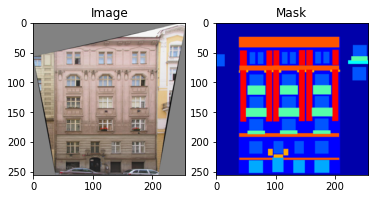

In [15]:
image, mask = next(iter(dataloader))
image = reverse_transform(image[0])
mask = reverse_transform(mask[0])
plot2x2Array(image, mask)

Initialize our GAN

In [0]:
# Calculate output of image discriminator (PatchGAN)
patch = (1, img_height//2**3-2, img_width//2**3-2)

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    criterion_GAN.cuda()
    criterion_pixelwise.cuda()
    
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Start training

In [0]:
def save_model(epoch):
    # save your work
    torch.save({
                'epoch': epoch,
                'model_state_dict': generator.state_dict(),
                'optimizer_state_dict': optimizer_G.state_dict(),
                'loss': loss_G,
                }, 'generator_'+str(epoch)+'.pth')
    torch.save({
                'epoch': epoch,
                'model_state_dict': discriminator.state_dict(),
                'optimizer_state_dict': optimizer_D.state_dict(),
                'loss': loss_D,
                }, 'discriminator_'+str(epoch)+'.pth')
    
def weights_init_normal(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
      torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm2d') != -1:
      torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
      torch.nn.init.constant_(m.bias.data, 0.0)

<font color='red'>Complete the loss function </font>  in the following training code and train your network:  

In [32]:
# ----------
#  Training
# ----------

losses = []
num_epochs = 200

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)
epoch_D = 0
epoch_G = 0

# train the network
discriminator.train()
generator.train()
print_every = 400

for epoch in range(epoch_G, num_epochs):
    for i, batch in enumerate(dataloader):

        # Model inputs
        real_A = Variable(batch[0].type(Tensor)) #image
        real_B = Variable(batch[1].type(Tensor)) #mask

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_B.size(0), *patch))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_B.size(0), *patch))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # GAN loss
        # TO DO: Put here your GAN loss

        optimizer_G.zero_grad()

        # Generate the fake output
        fake_A = generator(real_B)

        # Discriminate the fake and the real
        output = discriminator(fake_A.detach(), real_B)

        # Calculate generator GAN loss based on this output
        GAN_loss = criterion_GAN(output, valid)

        # Pixel-wise loss
        # TO DO: Put here your pixel loss

        # Calculate generator pixelwise loss
        pixelwise_loss = criterion_pixelwise(fake_A, real_A)

        # Total loss
        # TO DO: Put here your total loss
        loss_G = GAN_loss + lambda_pixel* pixelwise_loss

        # Backpropagate
        loss_G.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator(real_A, real_B)
        loss_real = criterion_GAN(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(fake_A.detach(), real_B)
        loss_fake = criterion_GAN(pred_fake, fake)

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake)

        loss_D.backward()
        optimizer_D.step()
        
        # Print some loss stats
        if i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch, num_epochs, loss_D.item(), loss_G.item()))
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((loss_D.item(), loss_G.item()))
    if epoch % 100 == 99:
        print('Saving model...')
        save_model(epoch+1)


Epoch [    0/  200] | d_loss: 0.3072 | g_loss: 47.2378
Epoch [    1/  200] | d_loss: 0.1434 | g_loss: 18.4301
Epoch [    2/  200] | d_loss: 0.0517 | g_loss: 20.1767
Epoch [    3/  200] | d_loss: 0.0288 | g_loss: 19.3040
Epoch [    4/  200] | d_loss: 0.0302 | g_loss: 17.5009
Epoch [    5/  200] | d_loss: 0.0282 | g_loss: 16.0162
Epoch [    6/  200] | d_loss: 0.0190 | g_loss: 15.3710
Epoch [    7/  200] | d_loss: 0.1572 | g_loss: 15.7282
Epoch [    8/  200] | d_loss: 0.0255 | g_loss: 14.9658
Epoch [    9/  200] | d_loss: 0.0600 | g_loss: 15.7317
Epoch [   10/  200] | d_loss: 0.1001 | g_loss: 13.8755
Epoch [   11/  200] | d_loss: 0.2863 | g_loss: 12.9526
Epoch [   12/  200] | d_loss: 0.1970 | g_loss: 13.1410
Epoch [   13/  200] | d_loss: 0.1552 | g_loss: 13.2730
Epoch [   14/  200] | d_loss: 0.0108 | g_loss: 12.7906
Epoch [   15/  200] | d_loss: 0.0035 | g_loss: 12.0442
Epoch [   16/  200] | d_loss: 0.0036 | g_loss: 12.6223
Epoch [   17/  200] | d_loss: 0.0018 | g_loss: 10.8738
Epoch [   

Observation of the loss along the training

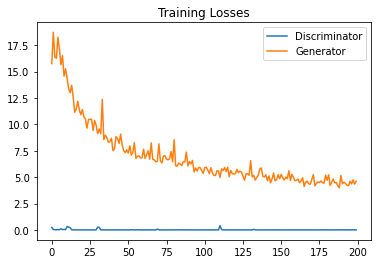

In [33]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()


If the training takes too much time, you can use a pretrained model in the meantime, to evaluate its performance.

It is available at : https://drive.google.com/drive/folders/10XHFrEztjdbQP2LiFlsk8e65Cyo1g6yN?usp=sharing

### Evaluate your cGAN

In [0]:
def load_model(epoch=200):
    if 'generator_'+str(epoch)+'.pth' in os.listdir() and 'discriminator_'+str(epoch)+'.pth' in os.listdir():
        if cuda:
            checkpoint_generator = torch.load('generator_'+str(epoch)+'.pth')
        else:
            checkpoint_generator = torch.load('generator_'+str(epoch)+'.pth', map_location='cpu')
        generator.load_state_dict(checkpoint_generator['model_state_dict'])
        optimizer_G.load_state_dict(checkpoint_generator['optimizer_state_dict'])
        epoch_G = checkpoint_generator['epoch']
        loss_G = checkpoint_generator['loss']

        if cuda:
            checkpoint_discriminator = torch.load('discriminator_'+str(epoch)+'.pth')
        else:
            checkpoint_discriminator = torch.load('discriminator_'+str(epoch)+'.pth', map_location='cpu')
        discriminator.load_state_dict(checkpoint_discriminator['model_state_dict'])
        optimizer_D.load_state_dict(checkpoint_discriminator['optimizer_state_dict'])
        epoch_D = checkpoint_discriminator['epoch']
        loss_D = checkpoint_discriminator['loss']
    else:
        print('There isn\' a training available with this number of epochs')

In [35]:
load_model(epoch=200)

# switching mode
generator.eval()

U_Net(
  (inc): inconv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down1): down(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down2): down(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down3): down(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inpla

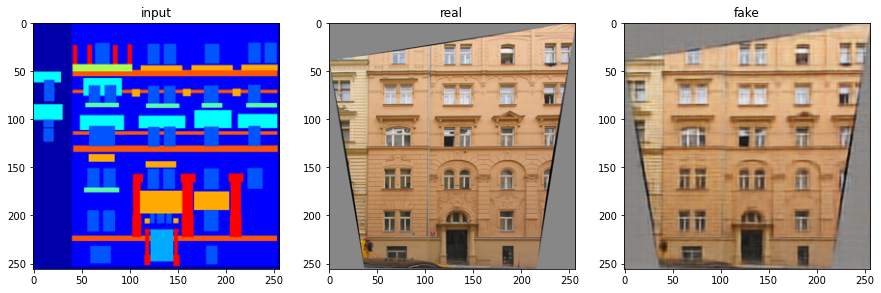

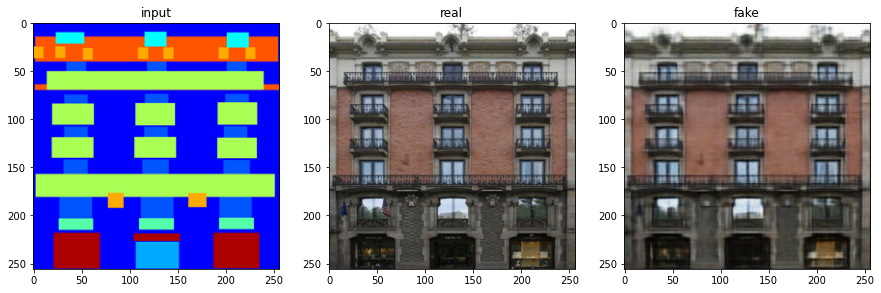

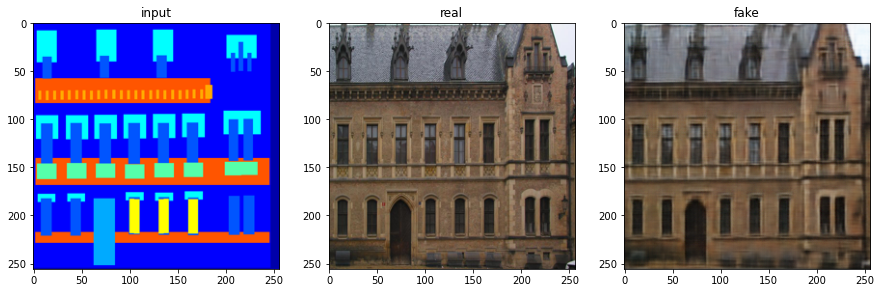

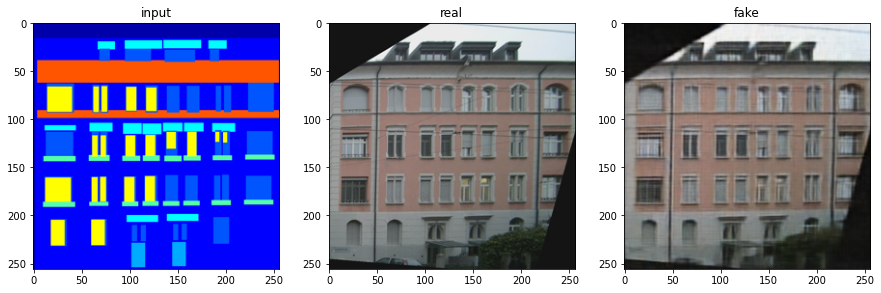

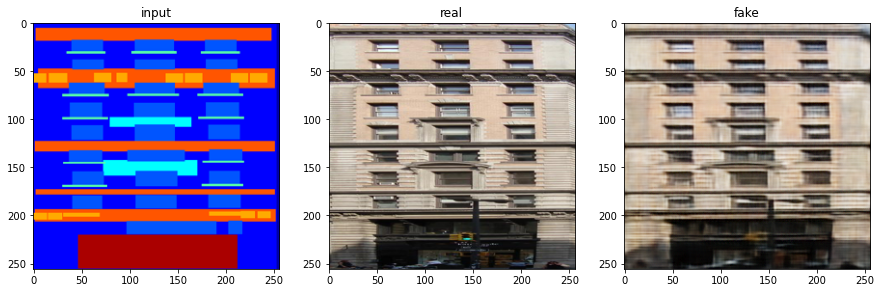

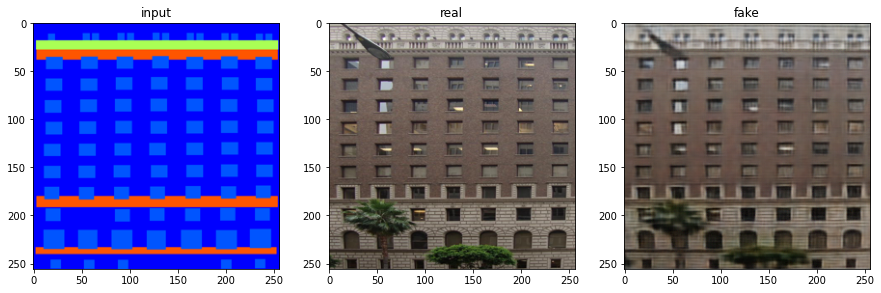

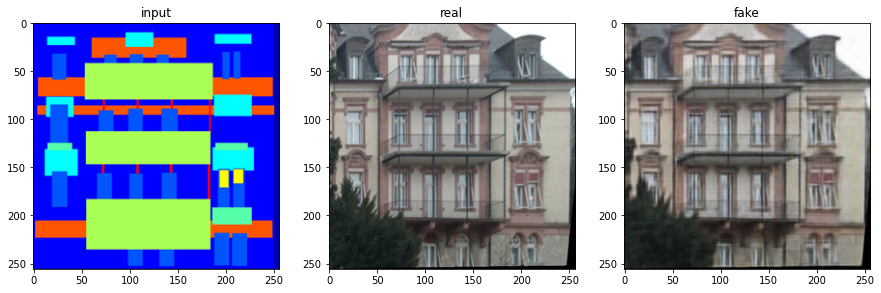

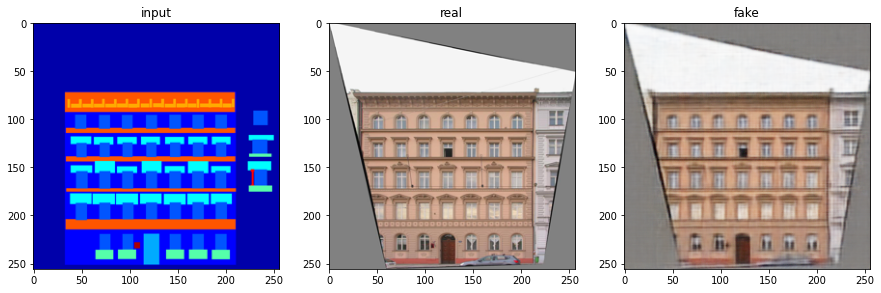

In [36]:
# show a sample evaluation image on the training base
image, mask = next(iter(dataloader))
output = generator(mask.type(Tensor))
output = output.view(-1, 3, 256, 256)
output = output.cpu().detach()
for i in range(8):
    image_plot = reverse_transform(image[i])
    output_plot = reverse_transform(output[i])
    mask_plot = reverse_transform(mask[i])
    plot2x3Array(mask_plot,image_plot,output_plot)

Outputs are very close to the real images. 

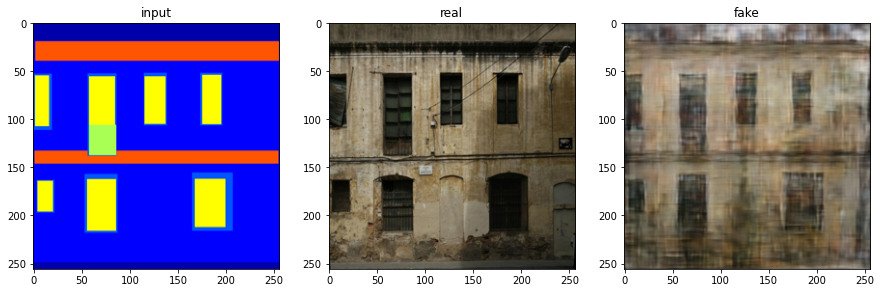

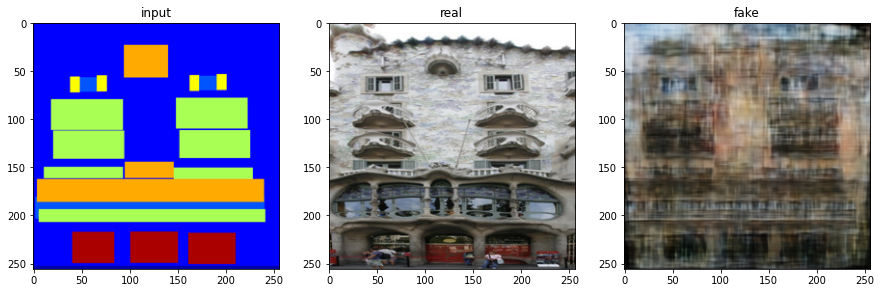

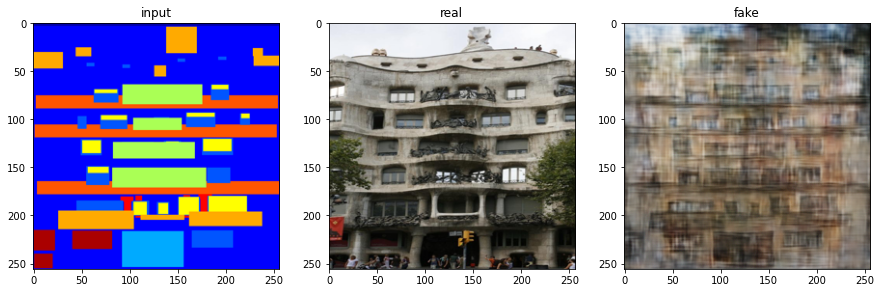

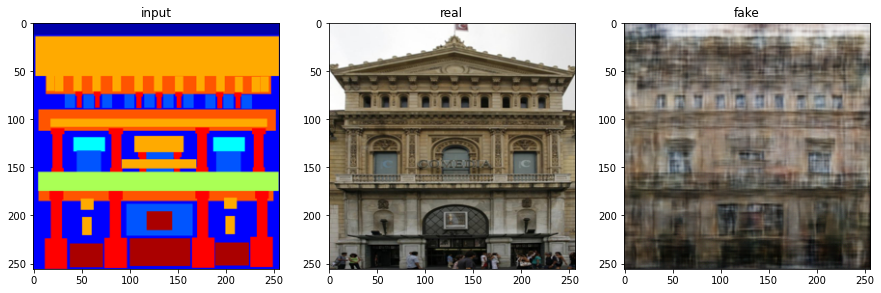

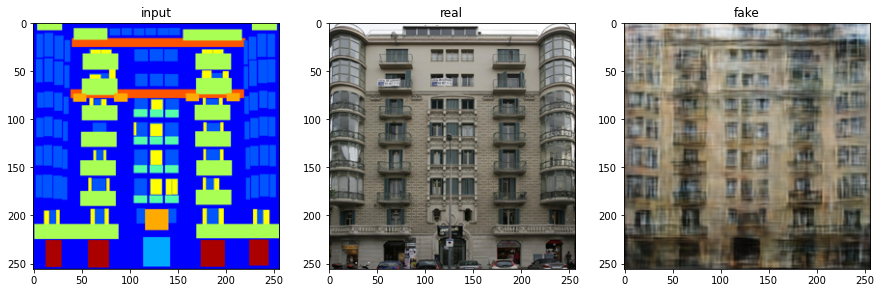

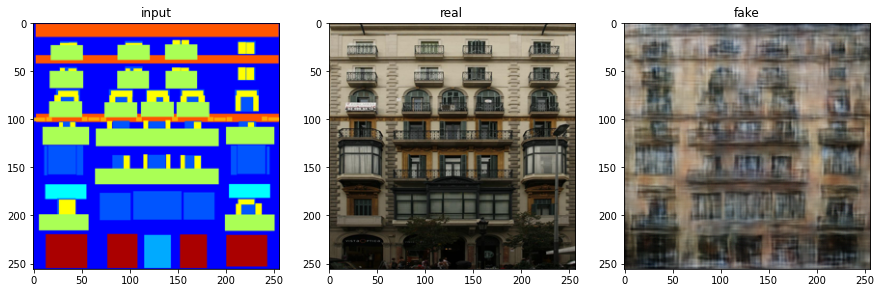

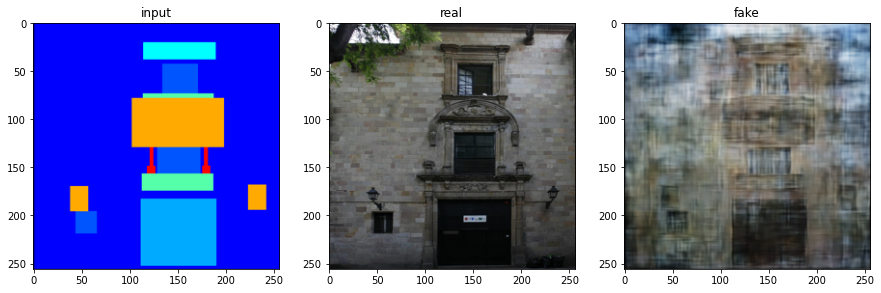

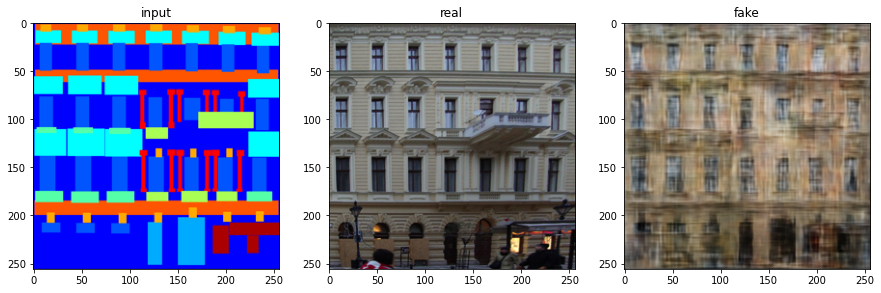

In [37]:
# show a sample evaluation image on the validation dataset
image, mask = next(iter(val_dataloader))
output = generator(mask.type(Tensor))
output = output.view(-1, 3, 256, 256)
output = output.cpu().detach()
for i in range(8):
    image_plot = reverse_transform(image[i])
    output_plot = reverse_transform(output[i])
    mask_plot = reverse_transform(mask[i])
    plot2x3Array(mask_plot,image_plot,output_plot)

The result on the validation set is satisfactory, even if they are visually much worse than on the training set.

<font color='red'>**Question 4**</font>                                                                  
Compare results for 100 and 200 epochs

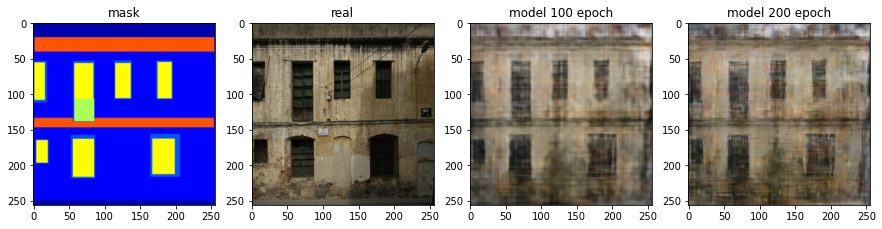

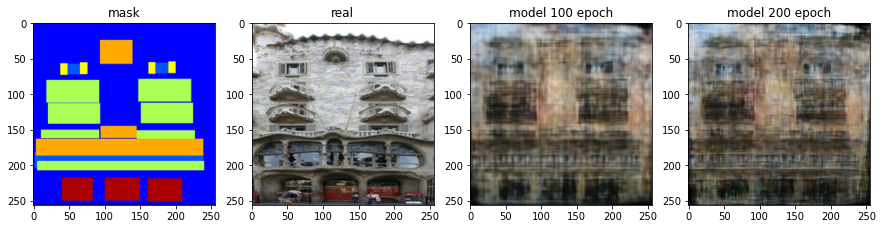

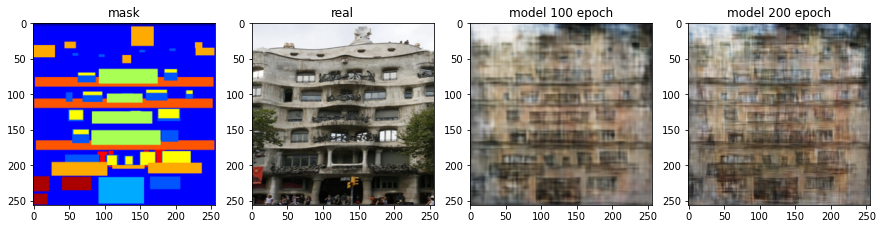

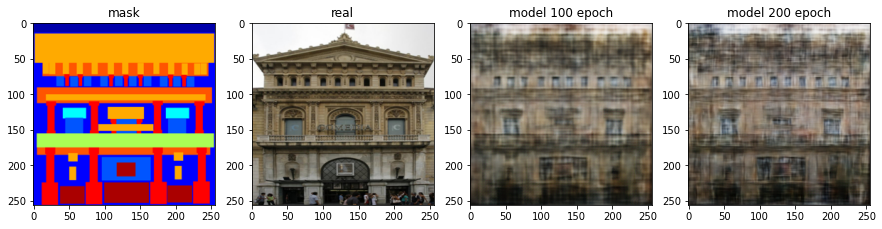

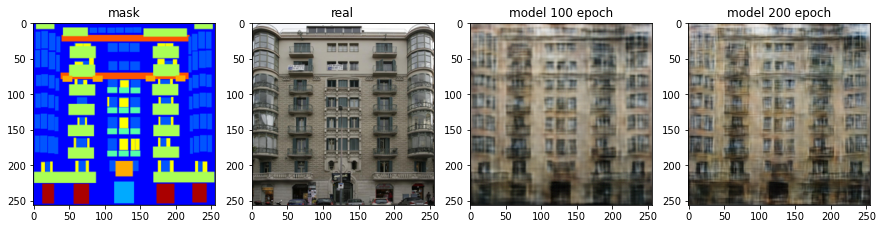

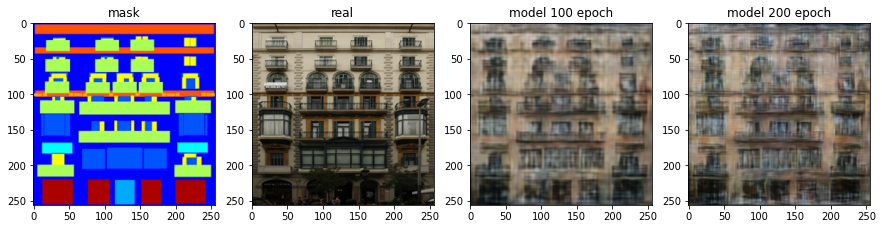

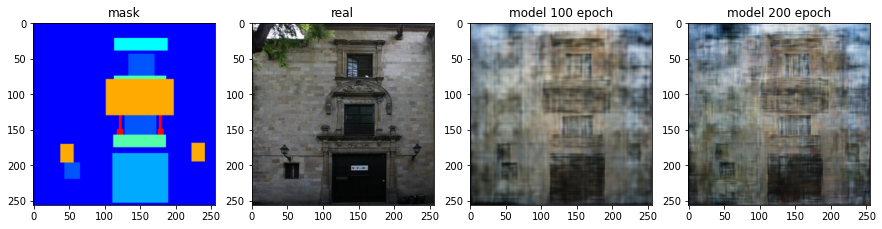

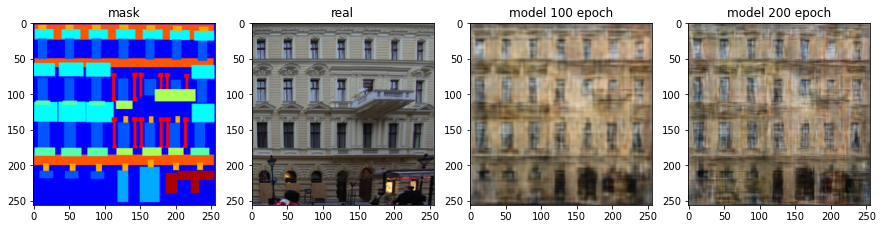

In [46]:
# TO DO : Your code here to load and evaluate with a few samples
#         a model after 100 epochs



  # show a sample evaluation image on the validation dataset

image, mask = next(iter(val_dataloader))

load_model(epoch=100)
generator.eval()

output_100 = generator(mask.type(Tensor))
output_100 = output_100.view(-1, 3, 256, 256)
output_100 = output_100.cpu().detach()

load_model(epoch=200)
generator.eval()

output_200 = generator(mask.type(Tensor))
output_200 = output_200.view(-1, 3, 256, 256)
output_200 = output_200.cpu().detach()

for i in range(8):
    output_plot100 = reverse_transform(output_100[i])
    output_plot200 = reverse_transform(output_200[i])
    image_plot = reverse_transform(image[i])
    mask_plot = reverse_transform(mask[i])

    f, axarr = plt.subplots(1,4,figsize=(15,15))
    axarr[0].imshow(mask_plot)
    axarr[1].imshow(image_plot)
    axarr[2].imshow(output_plot100)
    axarr[3].imshow(output_plot200)

    axarr[0].set_title('mask')
    axarr[1].set_title('real')
    axarr[2].set_title('model 100 epoch')
    axarr[3].set_title('model 200 epoch')



The results between Era 100 and Era 200 are very similar. It should be noted that the losses over the last 100 epochs have changed very little.

In [0]:
# And finally :
if cuda:
    torch.cuda.empty_cache()

# How to submit your Work ?
Your work should be uploaded within 3 weeks into the Moodle section "Devoir 2 - GAN et Conditional GAN". It can be either a notebook containing your code and a description of your work, experiments and results or a ".zip" file containing your report in a "pdf" format describing your work, experiments and results as well as your code (".py" Python files). 